In [34]:
import pandas as pd
import sqlite3

# Importing smaller movie_metedata via csv
# movies = pd.read_csv("movie_metadata.csv")
# movies.head()

# read movie data table from db into dataframe
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movies = pd.read_sql(sql, con)
# set max display to see all available columns
pd.set_option('display.max_columns', 500)
movies.head()
# Checking for duplicates...
movies['imdb_num_code'].value_counts()

tt0130018    1
tt2183034    1
tt0119925    1
tt1764234    1
tt0282209    1
tt0780511    1
tt0274558    1
tt0433383    1
tt0165710    1
tt3691740    1
tt0160399    1
tt0417976    1
tt0163025    1
tt0134618    1
tt1160368    1
tt0418647    1
tt0258273    1
tt1571222    1
tt0455590    1
tt0925248    1
tt0308208    1
tt0104839    1
tt0138304    1
tt1449283    1
tt0161081    1
tt0146336    1
tt0285462    1
tt1538403    1
tt0093378    1
tt0114614    1
            ..
tt0490204    1
tt0338216    1
tt1690953    1
tt0340855    1
tt0110912    1
tt0058331    1
tt0345061    1
tt0102713    1
tt1012804    1
tt0252299    1
tt0032138    1
tt0118771    1
tt0821642    1
tt0117958    1
tt1517260    1
tt0245674    1
tt1504320    1
tt1148165    1
tt0337741    1
tt0087298    1
tt0093300    1
tt0106226    1
tt0365885    1
tt0280707    1
tt0947802    1
tt0151804    1
tt0200027    1
tt0218043    1
tt0165929    1
tt0118928    1
Name: imdb_num_code, Length: 3637, dtype: int64

In [ ]:
# Print list of columns in smaller movies dataframe, in alphabetical order
for col in movies.columns.sort_values().values:
    print (col)

In [ ]:
movies_large = pd.read_csv('movies_metadata.csv')
movies_large = movies_large.set_index('imdb_id')
movies_large.head()

In [ ]:
for col in movies_large.columns.sort_values().values:
    print (col)

In [ ]:
movies.describe()
# Originally was ~4,900-5,100 records before re-pulling the data on 6/23 @ 8:21 pm...
# Believe it is because Seth dropped all N/A values
# New record count is not 3,738

In [ ]:
movies_large.describe()

In [ ]:
# Converting popularity from type 'object' to type 'numeric' (float)
movies['popularity'] = pd.to_numeric(movies['popularity'])
# Checking counts and types...nothing has changed.  
# Actually, there appears to be two more records now.  Why?
movies.describe()

In [ ]:
# Create new dataframe with just the production companies and genres from large dataset
movies_large_pc = movies_large[["production_companies","genres"]]
movies_large_pc.head()

In [ ]:
# Counting the number of production companies and genres per movie
movies_large_pc['production_companies_count'] = movies_large_pc['production_companies'].str.count('id')
movies_large_pc['genres_count'] = movies_large_pc['genres'].str.count('name')
movies_large_pc.head()

In [ ]:
# Add new columns to the existing movies table in sqllite db

# Columns straight from large dataset
movies = movies.merge(movies_large_pc[['production_companies_count','genres_count']], left_on="imdb_num_code", right_index=True, how="inner")
# Calculated columns based on occurrences of strings in certain columns
movies = movies.merge(movies_large[['popularity','vote_count','vote_average']], left_on="imdb_num_code", right_index=True, how="inner")
movies

# Definitions of new fields:

# Popularity: (Undetermined at this point on how this is calculated) - appears to be 0 to 100 rating scale.
# Vote Count: Number of users that voted for the movie on the TMDB website.
# Vote Average: Average score from the aforementioned votes.  
# Production Companies Count: Number of production companies that were a part of developing the movie.
# Genres Count: Number of genre classifications assigned to each movie.

# Website for large dataset:
# https://www.kaggle.com/rounakbanik/the-movies-dataset#movies_metadata.csv



In [ ]:
# Code to drop dups if the above cell is written multiple times
# movies = movies.drop(['popularity_x','vote_count_x','vote_average_x','production_companies_count_x',
#                     'genres_count_x','production_companies_count_y','genres_count_y','popularity_y',
#                     'vote_count_y','vote_average_y'],axis=1)


In [ ]:
# Seem to be duplicate records now...
movies['imdb_num_code'].value_counts()

# Also, why is there 128 duplicate records for tt0157472?

In [ ]:
# Remove duplicates
# removeDups2_movies = movies.drop_duplicates(subset ="imdb_num_code", 
#                      keep = 'first', inplace = True) 

In [ ]:
movies

##########################################

# Modelling

##########################################

## AdaBoost

In [115]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
con = sqlite3.connect("db/movies.db")

sql = f"""
   SELECT * FROM movie_data
   """

movies = pd.read_sql(sql, con)
# set max display to see all available columns
pd.set_option('display.max_columns', 500)
movies.sort_index(1).head()

,actor_1_facebook_likes,actor_1_name,actor_1_score,actor_2_facebook_likes,actor_2_name,actor_2_score,actor_3_facebook_likes,actor_3_name,actor_3_score,aspect_ratio,budget,cast_total_facebook_likes,color,content_rating,country,director_facebook_likes,director_name,director_score,duration,facenumber_in_poster,genres,genres_count,gross,gross_margin,holiday_month,imdb_num_code,imdb_score,language,movie_facebook_likes,movie_imdb_link,movie_title,num_critic_for_reviews,num_user_for_reviews,num_voted_users,plot_keywords,popularity,production_companies_count,rating_numeric,rel_mon_01,rel_mon_02,rel_mon_03,rel_mon_04,rel_mon_05,rel_mon_06,rel_mon_07,rel_mon_08,rel_mon_09,rel_mon_10,rel_mon_11,rel_mon_12,release_date,release_month,revenue,success_bins,successful,title_year,tot_noms,tot_wins,total_actor_starpower,vote_average,vote_count
0,1000.0,CCH Pounder,1.520767,936.0,Joel David Moore,1.747604,855.0,Wes Studi,2.066294,1.78,237000000.0,4834,Color,PG-13,USA,0.0,James Cameron,3.091853,178.0,0.0,Action|Adventure|Fantasy|Sci-Fi,4,760505847.0,0.688365,1,tt0499549,7.9,English,33000,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,Avatar,723.0,3054.0,886204,avatar|future|marine|native|paraplegic,185.070892,4.0,3,0,0,0,0,0,0,0,0,0,0,0,1,2009-12-10,12,523505847.0,extreme success,1,2009.0,0,0,5.334665,7.2,12114.0
1,3000.0,Djimon Hounsou,3.041534,1000.0,Jason Flemyng,5.825346,855.0,Wes Studi,2.066294,2.35,45000000.0,6558,Color,R,USA,208.0,Stephen Sommers,1.766773,106.0,0.0,Action|Adventure|Horror|Sci-Fi,4,11146409.0,-3.037175,0,tt0118956,6.0,English,0,http://www.imdb.com/title/tt0118956/?ref_=fn_t...,Deep Rising,106.0,273.0,26551,creature feature|hijacker|ocean|ship|shot in t...,6.922458,3.0,4,1,0,0,0,0,0,0,0,0,0,0,0,1998-01-30,01,-33853591.0,no success,0,1998.0,0,0,10.933174,6.0,155.0
2,23000.0,Christian Bale,8.364217,909.0,Michael Greyeyes,0.582535,855.0,Wes Studi,2.066294,2.35,30000000.0,27829,Color,PG-13,USA,0.0,Terrence Malick,1.325080,150.0,0.0,Biography|Drama|History|Romance,3,12712093.0,-1.359958,1,tt0402399,6.7,English,0,http://www.imdb.com/title/tt0402399/?ref_=fn_t...,The New World,222.0,671.0,70771,captain|fort|love|native american|trade,7.694502,5.0,3,0,0,0,0,0,0,0,0,0,0,0,1,2005-12-25,12,-17287907.0,no success,0,2005.0,0,0,11.013046,6.4,336.0
3,21000.0,Robert Downey Jr.,9.884984,936.0,Joel David Moore,1.747604,722.0,Kristin Davis,2.066294,2.35,50000000.0,24664,Color,PG,USA,48.0,Brian Robbins,2.650160,98.0,0.0,Comedy|Family|Fantasy,2,61112916.0,0.181842,0,tt0393735,4.4,English,747,http://www.imdb.com/title/tt0393735/?ref_=fn_t...,The Shaggy Dog,76.0,83.0,14888,animal as human|dog movie|elevator|human becom...,4.878907,3.0,2,0,0,1,0,0,0,0,0,0,0,0,0,2006-03-09,03,11112916.0,moderate success,1,2006.0,1,0,13.698882,4.5,138.0
4,14000.0,Josh Hutcherson,2.661342,12000.0,Dwayne Johnson,1.747604,722.0,Kristin Davis,2.066294,1.85,79000000.0,27842,Color,PG,USA,62.0,Brad Peyton,1.325080,94.0,3.0,Action|Adventure|Comedy|Family|Fantasy|Sci-Fi,3,103812241.0,0.239011,0,tt1397514,5.8,English,0,http://www.imdb.com/title/tt1397514/?ref_=fn_t...,Journey 2: The Mysterious Island,178.0,133.0,67296,gold|hurricane|island|mountain|mysterious island,9.46307,3.0,2,1,0,0,0,0,0,0,0,0,0,0,0,2012-01-19,01,24812241.0,average success,1,2012.0,0,0,6.475240,5.8,1050.0


In [6]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [123]:
# Load data
data = movies  [[
    
#                 "rating_numeric","director_score","production_companies_count",
#                 "total_actor_starpower","release_month","tot_wins","tot_noms"
    
#                 "director_facebook_likes", "cast_total_facebook_likes",
#                 "director_score","duration","facenumber_in_poster","genres_count",
#                 "holiday_month","imdb_score","movie_facebook_likes","production_companies_count",
#                 "rating_numeric","tot_noms","tot_wins","total_actor_starpower","vote_average"
    
                # Agreed upon 8 features - can be found and used in prediction before movie release
                'duration','rating_numeric', 'director_score','production_companies_count',
                "tot_wins","tot_noms", "total_actor_starpower", 'holiday_month'
    
#                 'rel_mon_01', 'rel_mon_02', 'rel_mon_03',
#                 'rel_mon_04', 'rel_mon_05', 'rel_mon_06', 'rel_mon_07', 'rel_mon_08', 'rel_mon_09',
#                 'rel_mon_10', 'rel_mon_11', 'rel_mon_12',


                ]]

to_predict = movies [["successful"]]
X = data
y = to_predict

In [124]:
X.head()

,duration,rating_numeric,director_score,production_companies_count,tot_wins,tot_noms,total_actor_starpower,holiday_month
0,178.0,3,3.091853,4.0,0,0,5.334665,1
1,106.0,4,1.766773,3.0,0,0,10.933174,0
2,150.0,3,1.325080,5.0,0,0,11.013046,1
3,98.0,2,2.650160,3.0,0,1,13.698882,0
4,94.0,2,1.325080,3.0,0,0,6.475240,0


In [125]:
# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

In [126]:
# # define hyper parameters Set
# params = {'max_features': ['auto', 'sqrt', 'log2'],
#           'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
#           'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
#           'random_state':[123]}

In [127]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1,
                        )
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# The most important parameters are base_estimator, n_estimators, and learning_rate.

# base_estimator: It is a weak learner used to train the model. It uses DecisionTreeClassifier as default weak learner for training purpose. You can also specify different machine learning algorithms.
# n_estimators: Number of weak learners to train iteratively.
# learning_rate: It contributes to the weights of weak learners. It uses 1 as a default value.

In [128]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5695970695970696


In [129]:
# Using Different Base Learners
# You can use any ML learner as base estimator if it accepts sample weight such as Decision Tree, Support Vector Classifier.

# # Load libraries
# from sklearn.ensemble import AdaBoostClassifier

# # Import Support Vector Classifier
# from sklearn.svm import SVC
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics

# svc=SVC(probability=True, kernel='poly')

# # Create adaboost classifer object
# abc = AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# # Train Adaboost Classifer
# model = abc.fit(X_train, y_train)

# #Predict the response for test dataset
# y_pred = model.predict(X_test)

# # Grid Search
# from sklearn.grid_search import GridSearchCV
# from sklearn.metrics import roc_curve, roc_auc_score

# # ROC Curve (Receiving Operator Characteristic)
# grid_search_ABC = GridSearchCV(abc, param_grid=params, scoring = 'roc_auc') 


# Model Accuracy, how often is the classifier correct?
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

In [130]:
from matplotlib.pyplot import figure
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

<Figure size 1332x756 with 0 Axes>

### Feature Importance - AdaBoost Model

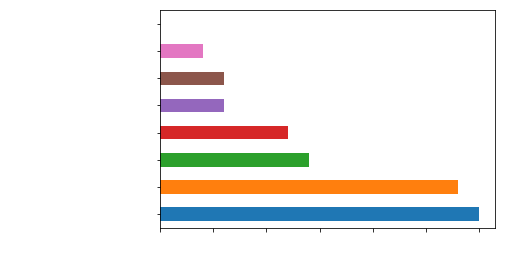

<Figure size 720x576 with 0 Axes>

In [131]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
label = plt.xlabel("Features")
label.set_color("white")
[i.set_color("white") for i in plt.gca().get_xticklabels()]
[i.set_color("white") for i in plt.gca().get_yticklabels()]
plt.figure(figsize=(10,8))
plt.show()



In [132]:
# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn

### AdaBoost with Principle Component Analysis (PCA) 

In [133]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets

In [134]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

In [136]:
# Function to test PCA with a range of component values

for n in range(2,9):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X_train, y_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    model.fit(X_train_pca, y_train)
    print("n="+str(n),model.score(X_test_pca, y_test),"")

n=2 0.5384615384615384 
n=3 0.5641025641025641 
n=4 0.5833333333333334 
n=5 0.5787545787545788 
n=6 0.5741758241758241 
n=7 0.5860805860805861 
n=8 0.5787545787545788 


In [98]:
pca.explained_variance_

array([5.39080179e+02, 2.33921539e+01, 4.85784433e+00, 3.91810585e+00,
       3.09754262e+00, 8.29079776e-01, 2.16387459e-01, 1.14427052e-01,
       9.83074084e-02])

In [99]:
pca.explained_variance_ratio_ 

array([9.35402426e-01, 4.05896532e-02, 8.42924587e-03, 6.79862823e-03,
       5.37480137e-03, 1.43860462e-03, 3.75471706e-04, 1.98551804e-04,
       1.70581283e-04])

In [100]:
# import numpy as np
# i = np.identity(len(X_train[0]))
# i
# pd.DataFrame(pca.transform(i))
# These column names are equivalent to rows 0-9 in pca.transform above
# movies.columns

### AdaBoost Model with PCA and Scaled X_train and X_test data

In [118]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train)
# transform the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [119]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train_scaled, y_train)

In [122]:
# Function to test PCA with a range of component values

for n in range(2,20):
    
    pca = decomposition.PCA(n_components = n)
    pca.fit(X_train_scaled, y_train)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    model.fit(X_train_pca, y_train)
    print("n="+str(n),model.score(X_test_pca, y_test))

n=2 0.5366300366300366
n=3 0.5393772893772893
n=4 0.5402930402930403
n=5 0.5439560439560439
n=6 0.554945054945055
n=7 0.5521978021978022
n=8 0.5384615384615384
n=9 0.5613553113553114
n=10 0.5467032967032966
n=11 0.5421245421245421
n=12 0.5576923076923077
n=13 0.554945054945055
n=14 0.5558608058608059
n=15 0.5622710622710623
n=16 0.5540293040293041
n=17 0.5586080586080586
n=18 0.5558608058608059
n=19 0.5558608058608059


In [105]:
# Updated ROC code for Bryan's notebook

# # predict probabilities
# probsNN = modelNN.predict_proba(X_test_scaled)
# probsRf = modelRf1.predict_proba(X_test_scaled)
# probsAda = model.predict_proba(X_test_scaled)

# # keep probabilities for the positive outcome only
# probsNN = probsNN[:, 1]
# probsRf = probsRf[:, 1]
# probsAda = probsAda[:, 1]

# # calculate AUC for NN and RF models
# aucNN = roc_auc_score(y_test, probsNN)
# aucRf = roc_auc_score(y_test, probsRf)
# aucAda = roc_auc_score(y_test, probsAda)
# print('Neural Network AUC (Area Under Curve): %.3f' % aucNN)
# print('Random Forest AUC (Area Under Curve): %.3f' % aucRf)
# print('Random Forest AUC (Area Under Curve): %.3f' % aucAda)
# print('\n')
# # calculate roc curve
# fprNN, tprNN, thresholdsNN = roc_curve(y_test, probsNN)
# fprRf, tprRf, thresholdsRf = roc_curve(y_test, probsRf)
# fprAda, tprAda, thresholdsAda = roc_curve(y_test, probsAda)

# # plot no skill
# pyplot.plot([0, 1], [0, 1], linestyle='--', label="Random")
# # plot the Neural Network roc curve
# pyplot.plot(fprNN, tprNN, marker='.', label="Neural Network")
# # plot the Random Forest ROC curve 
# pyplot.plot(fprRf, tprRf, marker = '.', label = "Random Forest")
# # plot the Random Forest ROC curve 
# pyplot.plot(fprAda, tprAda, marker = '.', label = "AdaBoost")
# # title
# plt.title('ROC Curve', fontsize = 16)
# # legend
# plt.legend(loc = 'lower right', fontsize = 10)
# # show the plot
# pyplot.show()

### AdaBoost with RandomizedSearchCV and Hyper Parameter Tuning

In [110]:
from sklearn.model_selection import RandomizedSearchCV

param = {
'n_estimators': [50, 100],
'learning_rate' : [0.01,0.05,0.1,0.3,1],
'loss' : ['linear', 'square', 'exponential']
}

rscv_abc = RandomizedSearchCV(AdaBoostClassifier(),
param_distributions = params,
cv=3,
n_iter = 10,
n_jobs=-1)

In [113]:
# This is erroring out...
# Train Adaboost Classifer
model = rscv_abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\ryanz\Anaconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\ryanz\Anaconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x000001E4B4C94660, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ryanz\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\r...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001E4B4C94660, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ryanz\Anaconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\r...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    494         if self.poller is not None:
    495             self.poller.start()
    496         self.kernel.start()
    497         self.io_loop = ioloop.IOLoop.current()
    498         try:
--> 499             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    500         except KeyboardInterrupt:
    501             pass
    502 
    503 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
C:\Users\ryanz\Anaconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
C:\Users\ryanz\Anaconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(848, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
C:\Users\ryanz\Anaconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(848, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (848, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=848, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 7, 1, 21, 58, 56, 215558, tzinfo=tzutc()), 'msg_id': 'bc39d068ef90490ba878849904cc3c57', 'msg_type': 'execute_request', 'session': '2232d6c90a7c44b4814458a72941d97d', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39d068ef90490ba878849904cc3c57', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2232d6c90a7c44b4814458a72941d97d']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 7, 1, 21, 58, 56, 215558, tzinfo=tzutc()), 'msg_id': 'bc39d068ef90490ba878849904cc3c57', 'msg_type': 'execute_request', 'session': '2232d6c90a7c44b4814458a72941d97d', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39d068ef90490ba878849904cc3c57', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2232d6c90a7c44b4814458a72941d97d'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2019, 7, 1, 21, 58, 56, 215558, tzinfo=tzutc()), 'msg_id': 'bc39d068ef90490ba878849904cc3c57', 'msg_type': 'execute_request', 'session': '2232d6c90a7c44b4814458a72941d97d', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'bc39d068ef90490ba878849904cc3c57', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = '# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='# Train Adaboost Classifer\nmodel = rscv_abc.fit(...ccuracy:",metrics.accuracy_score(y_test, y_pred))', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-113-5e62cb0369f6>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1e4ce933198, executio...rue silent=False shell_futures=True> result=None>)
   2896             raise ValueError("Interactivity was %r" % interactivity)
   2897         try:
   2898             for i, node in enumerate(to_run_exec):
   2899                 mod = ast.Module([node])
   2900                 code = compiler(mod, cell_name, "exec")
-> 2901                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001E4CFD8C780, file "<ipython-input-113-5e62cb0369f6>", line 2>
        result = <ExecutionResult object at 1e4ce933198, executio...rue silent=False shell_futures=True> result=None>
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001E4CFD8C780, file "<ipython-input-113-5e62cb0369f6>", line 2>, result=<ExecutionResult object at 1e4ce933198, executio...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001E4CFD8C780, file "<ipython-input-113-5e62cb0369f6>", line 2>
        self.user_global_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'In': ['', 'pca.explained_variance_\npca.explained_variance_ratio_', 'import pandas as pd\nimport sqlite3\nimport matplotlib.pyplot as plt', 'con = sqlite3.connect("db/movies.db")\n\nsql = f""...ay.max_columns\', 500)\nmovies.sort_index(1).head()', '# Load data\ndata = movies  [[\n    \n#            ...= movies [["successful"]]\nX = data\ny = to_predict', '# Split dataset into training set and test set\n#..., y_test = train_test_split(X, y, test_size=0.3) ', '# Load libraries\nfrom sklearn.ensemble import Ad... accuracy calculation\nfrom sklearn import metrics', '# Load data\ndata = movies  [[\n    \n#            ...= movies [["successful"]]\nX = data\ny = to_predict', '# Split dataset into training set and test set\n#..., y_test = train_test_split(X, y, test_size=0.3) ', "# define hyper parameters Set\nparams = {'max_fea...5,6,7,8,9,10,11],\n          'random_state':[123]}", '# Create adaboost classifer object\nabc = AdaBoos...s of weak learners. It uses 1 as a default value.', '# Model Accuracy, how often is the classifier co...ccuracy:",metrics.accuracy_score(y_test, y_pred))', '# Using Different Base Learners\n# You can use an...curacy:", metrics.accuracy_score(y_test, y_pred))', 'from matplotlib.pyplot import figure\nfig = plt.gcf()\nfig.set_size_inches(18.5, 10.5)', '# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn', 'from mpl_toolkits.mplot3d import Axes3D\nfrom skl...import decomposition\nfrom sklearn import datasets', '# define model; CHANGE FOR YOUR MODEL\n# Create a...boost Classifer\nmodel = abc.fit(X_train, y_train)', '# Function to test PCA with a range of component...t("n="+str(n),model.score(X_test_pca, y_test),"")', 'pca.explained_variance_\npca.explained_variance_ratio_', 'pca.explained_variance_', ...], 'Out': {3:    actor_1_facebook_likes       actor_1_name  ac...             6.475240           5.8      1050.0  , 18: array([9.33385697e-01, 4.26753351e-02, 8.9815233...0062e-04, 1.86281202e-04,
       1.81460882e-04]), 19: array([5.13078647e+02, 2.34584730e+01, 4.9371100...9925e-01, 1.02398084e-01,
       9.97483721e-02]), 20: array([9.33385697e-01, 4.26753351e-02, 8.9815233...0062e-04, 1.86281202e-04,
       1.81460882e-04]), 33: array([5.06440988e+02, 2.39316869e+01, 5.1435231...6901e-01, 1.12831472e-01,
       1.00506050e-01]), 34: array([9.30271547e-01, 4.39596476e-02, 9.4480370...9213e-04, 2.07257925e-04,
       1.84617598e-04]), 39:       duration  rating_numeric  director_score  ...     0              0  

[3637 rows x 20 columns], 46:       duration  rating_numeric  director_score  ...     0              0  

[3637 rows x 20 columns], 47:    duration  rating_numeric  director_score  pro...       0           0           0              0  , 59: array([5.39080179e+02, 2.33921539e+01, 4.8578443...7459e-01, 1.14427052e-01,
       9.83074084e-02]), ...}, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X':       duration  rating_numeric  director_score  ...     0              0  

[3637 rows x 20 columns], 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'X_test':       duration  rating_numeric  director_score  ...     0              1  

[1092 rows x 20 columns], 'X_test_pca': array([[-1.66702544e+00, -1.15830073e-01,  4.099...10895137e-01,  2.62415825e+00,  3.70268463e-01]]), ...}
        self.user_ns = {'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'Axes3D': <class 'mpl_toolkits.mplot3d.axes3d.Axes3D'>, 'In': ['', 'pca.explained_variance_\npca.explained_variance_ratio_', 'import pandas as pd\nimport sqlite3\nimport matplotlib.pyplot as plt', 'con = sqlite3.connect("db/movies.db")\n\nsql = f""...ay.max_columns\', 500)\nmovies.sort_index(1).head()', '# Load data\ndata = movies  [[\n    \n#            ...= movies [["successful"]]\nX = data\ny = to_predict', '# Split dataset into training set and test set\n#..., y_test = train_test_split(X, y, test_size=0.3) ', '# Load libraries\nfrom sklearn.ensemble import Ad... accuracy calculation\nfrom sklearn import metrics', '# Load data\ndata = movies  [[\n    \n#            ...= movies [["successful"]]\nX = data\ny = to_predict', '# Split dataset into training set and test set\n#..., y_test = train_test_split(X, y, test_size=0.3) ', "# define hyper parameters Set\nparams = {'max_fea...5,6,7,8,9,10,11],\n          'random_state':[123]}", '# Create adaboost classifer object\nabc = AdaBoos...s of weak learners. It uses 1 as a default value.', '# Model Accuracy, how often is the classifier co...ccuracy:",metrics.accuracy_score(y_test, y_pred))', '# Using Different Base Learners\n# You can use an...curacy:", metrics.accuracy_score(y_test, y_pred))', 'from matplotlib.pyplot import figure\nfig = plt.gcf()\nfig.set_size_inches(18.5, 10.5)', '# https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn', 'from mpl_toolkits.mplot3d import Axes3D\nfrom skl...import decomposition\nfrom sklearn import datasets', '# define model; CHANGE FOR YOUR MODEL\n# Create a...boost Classifer\nmodel = abc.fit(X_train, y_train)', '# Function to test PCA with a range of component...t("n="+str(n),model.score(X_test_pca, y_test),"")', 'pca.explained_variance_\npca.explained_variance_ratio_', 'pca.explained_variance_', ...], 'Out': {3:    actor_1_facebook_likes       actor_1_name  ac...             6.475240           5.8      1050.0  , 18: array([9.33385697e-01, 4.26753351e-02, 8.9815233...0062e-04, 1.86281202e-04,
       1.81460882e-04]), 19: array([5.13078647e+02, 2.34584730e+01, 4.9371100...9925e-01, 1.02398084e-01,
       9.97483721e-02]), 20: array([9.33385697e-01, 4.26753351e-02, 8.9815233...0062e-04, 1.86281202e-04,
       1.81460882e-04]), 33: array([5.06440988e+02, 2.39316869e+01, 5.1435231...6901e-01, 1.12831472e-01,
       1.00506050e-01]), 34: array([9.30271547e-01, 4.39596476e-02, 9.4480370...9213e-04, 2.07257925e-04,
       1.84617598e-04]), 39:       duration  rating_numeric  director_score  ...     0              0  

[3637 rows x 20 columns], 46:       duration  rating_numeric  director_score  ...     0              0  

[3637 rows x 20 columns], 47:    duration  rating_numeric  director_score  pro...       0           0           0              0  , 59: array([5.39080179e+02, 2.33921539e+01, 4.8578443...7459e-01, 1.14427052e-01,
       9.83074084e-02]), ...}, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'StandardScaler': <class 'sklearn.preprocessing.data.StandardScaler'>, 'X':       duration  rating_numeric  director_score  ...     0              0  

[3637 rows x 20 columns], 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'X_test':       duration  rating_numeric  director_score  ...     0              1  

[1092 rows x 20 columns], 'X_test_pca': array([[-1.66702544e+00, -1.15830073e-01,  4.099...10895137e-01,  2.62415825e+00,  3.70268463e-01]]), ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
C:\Users\ryanz\Desktop\Data Analytics Bootcamp\Resources\Modules\My Projects\1 - Applications\project_3\<ipython-input-113-5e62cb0369f6> in <module>()
      1 # Train Adaboost Classifer
----> 2 model = rscv_abc.fit(X_train, y_train)
      3 
      4 #Predict the response for test dataset
      5 y_pred = model.predict(X_test)
      6 
      7 print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=3, error_score='raise',
  ...turn_train_score='warn', scoring=None, verbose=0), X=      duration  rating_numeric  director_score  ...     0              0  

[2545 rows x 20 columns], y=      successful
1814           1
718           ...      1
431            0

[2545 rows x 1 columns], groups=None, **fit_params={})
    635                                   return_train_score=self.return_train_score,
    636                                   return_n_test_samples=True,
    637                                   return_times=True, return_parameters=False,
    638                                   error_score=self.error_score)
    639           for parameters, (train, test) in product(candidate_params,
--> 640                                                    cv.split(X, y, groups)))
        cv.split = <bound method StratifiedKFold.split of Stratifie...ld(n_splits=3, random_state=None, shuffle=False)>
        X =       duration  rating_numeric  director_score  ...     0              0  

[2545 rows x 20 columns]
        y =       successful
1814           1
718           ...      1
431            0

[2545 rows x 1 columns]
        groups = None
    641 
    642         # if one choose to see train score, "out" will contain train score info
    643         if self.return_train_score:
    644             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Jul  1 17:58:57 2019
PID: 56824                Python 3.7.0: C:\Users\ryanz\Anaconda3\python.exe
...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None),       duration  rating_numeric  director_score  ...       0              0

[2545 rows x 20 columns],       successful
1814           1
718           ...      1
431            0

[2545 rows x 1 columns], {'score': <function _passthrough_scorer>}, array([ 798,  799,  802, ..., 2542, 2543, 2544]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 893, 895, 896, 897,
       900, 902, 905, 911]), 0, {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None),       duration  rating_numeric  director_score  ...       0              0

[2545 rows x 20 columns],       successful
1814           1
718           ...      1
431            0

[2545 rows x 1 columns], {'score': <function _passthrough_scorer>}, array([ 798,  799,  802, ..., 2542, 2543, 2544]), array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 893, 895, 896, 897,
       900, 902, 905, 911]), 0, {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None), X=      duration  rating_numeric  director_score  ...       0              0

[2545 rows x 20 columns], y=      successful
1814           1
718           ...      1
431            0

[2545 rows x 1 columns], scorer={'score': <function _passthrough_scorer>}, train=array([ 798,  799,  802, ..., 2542, 2543, 2544]), test=array([  0,   1,   2,   3,   4,   5,   6,   7,  ..., 893, 895, 896, 897,
       900, 902, 905, 911]), verbose=0, parameters={'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method BaseEstimator.set_params of AdaBoo...ng_rate=1.0, n_estimators=50, random_state=None)>
        parameters = {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
C:\Users\ryanz\Anaconda3\lib\site-packages\sklearn\base.py in set_params(self=AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None), **params={'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50})
    269             key, delim, sub_key = key.partition('__')
    270             if key not in valid_params:
    271                 raise ValueError('Invalid parameter %s for estimator %s. '
    272                                  'Check the list of available parameters '
    273                                  'with `estimator.get_params().keys()`.' %
--> 274                                  (key, self))
        key = 'loss'
        self = AdaBoostClassifier(algorithm='SAMME.R', base_est...ing_rate=1.0, n_estimators=50, random_state=None)
    275 
    276             if delim:
    277                 nested_params[key][sub_key] = value
    278             else:

ValueError: Invalid parameter loss for estimator AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None). Check the list of available parameters with `estimator.get_params().keys()`.
___________________________________________________________________________